# MIE 1624 Introduction to Data Science and Analytics – Winter 2019
## Assignment 2
### Krutheeka Rajkumar
### 1004689553

In [1]:
import pandas as pd
import numpy as np
#import os
#Progress bar
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error

# Using a small subset of original data
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.cross_validation import KFold # old version
import time
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures


#plotting
import matplotlib.pyplot as plt
import seaborn as sns
cur_dir = os.getcwd()
from matplotlib.pyplot import boxplot
from matplotlib.axes import Axes


In [2]:
# Using a small subset of original data
# full data can be found on Kaggle : https://www.kaggle.com/c/job-salary-prediction
Salaries = pd.read_csv("kaggle_salary.csv", encoding = "ISO-8859-1") 
#Salaries_Train,Salaries_Test = train_test_split(Salaries,test_size=0.33, random_state=13)
Salaries.shape

/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(15430, 397)

In [3]:
Salaries.head()
# Droping the ROW with the questions 
Salaries = Salaries.drop([0])
Salaries.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
1,2,434,Male,-1,30-34,Indonesia,Bachelorâs degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Masterâs degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
5,8,1758,Male,-1,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,2,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


In [4]:
#Salaries.sort_values(by=['Q9'])
Sal = Salaries['Q9']
Salaries["Q9"] = pd.to_numeric(Salaries.Q9)
#Salaries = Salaries.sort_values(by = ['Q9'])

## 1) DATA CLEANING:
The information in columns with captions other- text with numbers (generally filled with -1) seem to be meaning less. They are attached to questions which have multiple choices where the person taking the survey is able to choose from a list of preset options. This set of information is more valuable than the last column attached to these questions. Therefore those is the first column that are removed. <br> The missing data was filled in depending on the previously answered questions. The questions with the multiple choices were not manipulated since they are already featurized. 

In [5]:
titles = list(Salaries)
to_drop = []
for title in titles:
    if 'TEXT' in title:
        to_drop.append(title)
print(to_drop)
Salaries = Salaries.drop(to_drop, axis = 1)
#Salaries

['Q1_OTHER_TEXT', 'Q6_OTHER_TEXT', 'Q7_OTHER_TEXT', 'Q11_OTHER_TEXT', 'Q12_Part_1_TEXT', 'Q12_Part_2_TEXT', 'Q12_Part_3_TEXT', 'Q12_Part_4_TEXT', 'Q12_Part_5_TEXT', 'Q12_OTHER_TEXT', 'Q13_OTHER_TEXT', 'Q14_OTHER_TEXT', 'Q15_OTHER_TEXT', 'Q16_OTHER_TEXT', 'Q17_OTHER_TEXT', 'Q18_OTHER_TEXT', 'Q19_OTHER_TEXT', 'Q20_OTHER_TEXT', 'Q21_OTHER_TEXT', 'Q22_OTHER_TEXT', 'Q27_OTHER_TEXT', 'Q28_OTHER_TEXT', 'Q29_OTHER_TEXT', 'Q30_OTHER_TEXT', 'Q31_OTHER_TEXT', 'Q33_OTHER_TEXT', 'Q34_OTHER_TEXT', 'Q35_OTHER_TEXT', 'Q36_OTHER_TEXT', 'Q37_OTHER_TEXT', 'Q38_OTHER_TEXT', 'Q42_OTHER_TEXT', 'Q49_OTHER_TEXT', 'Q50_OTHER_TEXT']


In [6]:
#Dropping "Time from Start to Finish (seconds)" 
Salaries = Salaries.drop('Time from Start to Finish (seconds)', axis=1)
# Dropping the fist column "Unknown: 0"
to_drop = Salaries.iloc[:,0:1]
Salaries = Salaries.drop(to_drop, axis = 1)

In [7]:
Salaries.shape

(15429, 361)

Examining each of the survey questions that are not multiple choice questions <br> 
<b>Q1: What is your gender? - Selected Choice</b> <br>
0: missing entries
  

In [8]:
print("Values that were absent in this question: ",Salaries['Q1'].isnull().sum(axis=0))
Salaries['Q1'].value_counts(normalize = True)

Values that were absent in this question:  0


Male                       0.833884
Female                     0.154255
Prefer not to say          0.008426
Prefer to self-describe    0.003435
Name: Q1, dtype: float64

<b>Q2: Age range of the applicants</b> <br> 0: missing entries

In [9]:
print("Values that were absent in this question: ",Salaries['Q2'].isnull().sum(axis=0) )
Salaries['Q2'].value_counts(normalize = True)

Values that were absent in this question:  0


25-29    0.277270
22-24    0.187569
30-34    0.182708
35-39    0.106099
18-21    0.088340
40-44    0.064100
45-49    0.039017
50-54    0.026120
55-59    0.014388
60-69    0.011666
70-79    0.001685
80+      0.001037
Name: Q2, dtype: float64

<b>Q3: In which country do you currently reside?</b> <br> 0: missing entries

In [10]:
print("Values that were absent in this question: ",Salaries['Q3'].isnull().sum(axis=0) )
print(Salaries['Q3'].value_counts(normalize = True))

Values that were absent in this question:  0
United States of America                                0.219911
India                                                   0.150366
China                                                   0.056387
Other                                                   0.043878
Russia                                                  0.037656
Brazil                                                  0.036101
Germany                                                 0.032795
United Kingdom of Great Britain and Northern Ireland    0.032082
Canada                                                  0.028583
France                                                  0.027416
Japan                                                   0.026703
Spain                                                   0.023592
Italy                                                   0.015814
Australia                                               0.015166
Poland                                       

<b>Q4: What is the highest level of formal education that you have attained or plan to attain within the next 2 years?</b> <br> 0: missing entries<br> There were 136 entries where the option chosen was "no formal education past high school" - since this is a small number of entries and it can be presumed that the correlation between these individuals and the insight they would have to offer with regards to being a data scientist/analyst would be mostly invalid. Therefore, these rows were dropped

In [11]:
print("Values that were absent in this question: ",Salaries['Q4'].isnull().sum(axis=0) )
Salaries['Q4'].value_counts(normalize = True)

Values that were absent in this question:  0


Masterâs degree                                                      0.472228
Bachelorâs degree                                                    0.284075
Doctoral degree                                                        0.163458
Some college/university study without earning a bachelorâs degree    0.038175
Professional degree                                                    0.024888
No formal education past high school                                   0.008750
I prefer not to answer                                                 0.008426
Name: Q4, dtype: float64

In [12]:
no_ed = Salaries[Salaries['Q4']=='No formal education past high school']
no_ed_in = no_ed.index
#Salaries = Salaries.drop(Salaries[Salaries['Q4']=='No formal education past high school']], axis = 0)
Salaries = Salaries[~Salaries['Q4'].str.contains("No formal education")]
Salaries.shape
#no_ed_in

(15294, 361)

##### Q5: Which best describes your undergraduate major? - Selected Choice
134: missing entries <br>
****** of the entires were not answered for this question- upon cross checking the level of education and the declared college major it was evident that the surveyee did not go past high school- hence did not declare a major in college.
The previous section dropped the rows that where the surveeys did not have a formal education past night school, and these rows were dropped here as well. 

In [13]:
print("Values that were absent in this question: ",Salaries['Q5'].isnull().sum(axis=0) )
Salaries['Q5'].value_counts(normalize = False)
nos = len(Salaries)
sal = Salaries['Q5'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  0
Percentage of missing data:  0.0 %


In [14]:
# Before dropping the previous rows, there was a 100% corelation between
# the missing values from Q5 and "no formal education" section of Q4
a = Salaries['Q4'].value_counts(normalize=True)
b = Salaries[Salaries['Q5'].isnull()]['Q4'].value_counts(normalize=True)
print (pd.DataFrame({'Edu Qualifications': a, 'Major':b}))

                                                    Edu Qualifications  Major
Bachelorâs degree                                           0.286583    NaN
Doctoral degree                                               0.164901    NaN
I prefer not to answer                                        0.008500    NaN
Masterâs degree                                             0.476396    NaN
Professional degree                                           0.025108    NaN
Some college/university study without earning a...            0.038512    NaN


|Degrees                                                       |EDU         |Maj|
|--------------------------------------------------------------|------------|---|
|Bachelorâs degree                                           |0.284057    |NaN|
|Doctoral degree                                               |0.163448    |NaN|
|I prefer not to answer                                        |0.008425    |NaN|
|Masterâs degree                                             |0.472197    |NaN|
|No formal education past high school                          |0.008749    |1.0|
|Professional degree                                           |0.024887    |NaN|
|Some college/university study without earning a...            |0.038172    |NaN|
|What is the highest level of formal education t...            |0.000065    |NaN|

In [15]:
# The rows were automatically dropped. 
#Salaries['Q5'].fillna('No College Education',inplace=True)
#Salaries['Q4'].value_counts(normalize=True)
Salaries.shape

(15294, 361)

<b>Q6: Select the title most similar to your current role (or most recent title if retired): - Selected Choice</b><br>
0: missing entries<br>
Since the students have no real world experience and there would be no correlation between their salary and their current role as a student. These rows were also dropped. This cleans the dataset quite a bit as 17% of the people taking the survey were students.

In [16]:
print("Values that were absent in this question: ",Salaries['Q6'].isnull().sum(axis=0) )
Salaries['Q6'].value_counts(normalize = True)

Values that were absent in this question:  0


Data Scientist             0.211325
Student                    0.170524
Software Engineer          0.150386
Data Analyst               0.092651
Other                      0.066039
Research Scientist         0.059958
Business Analyst           0.037858
Consultant                 0.037270
Data Engineer              0.036550
Manager                    0.029489
Research Assistant         0.029227
Product/Project Manager    0.021381
Chief Officer              0.015954
Statistician               0.011704
DBA/Database Engineer      0.007454
Developer Advocate         0.005558
Marketing Analyst          0.005492
Principal Investigator     0.005427
Salesperson                0.005100
Data Journalist            0.000654
Name: Q6, dtype: float64

In [17]:
Salaries = Salaries[~Salaries['Q6'].str.contains("Student")]
Salaries.shape

(12686, 361)

##### Q7: In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
0: missing entries<br> There is a category "I am a student" which still exists in this column, the assumption made is that these are perhaps interns and they make up 3% of the total list. These rows are dropped again.

In [18]:
print("Values that were absent in this question: ",Salaries['Q7'].isnull().sum(axis=0) )
Salaries['Q7'].value_counts(normalize = True)

Values that were absent in this question:  0


Computers/Technology                      0.308687
Academics/Education                       0.123443
Accounting/Finance                        0.089705
Other                                     0.057701
Online Service/Internet-based Services    0.054233
Medical/Pharmaceutical                    0.044616
Government/Public Service                 0.039571
I am a student                            0.034842
Insurance/Risk Assessment                 0.034842
Manufacturing/Fabrication                 0.033107
Marketing/CRM                             0.029087
Retail/Sales                              0.026801
Energy/Mining                             0.025855
Broadcasting/Communications               0.024594
Online Business/Internet-based Sales      0.020810
Shipping/Transportation                   0.018209
Non-profit/Service                        0.011509
Hospitality/Entertainment/Sports          0.011430
Military/Security/Defense                 0.010957
Name: Q7, dtype: float64

In [19]:
Salaries = Salaries[~Salaries['Q7'].str.contains("I am a student")]
Salaries.shape

(12244, 361)

##### Q8: How many years of experience do you have in your current role?
8 entries missing <br>
After dropping the previous rows the number of missing data dropped from 49% to 6% indicating that most of the missing entries were from students. The missing rows are not dropped however, as they might belong to recently graduated students in their first year of their careers and might have some insight into the skills they acquired to be able to get that job in the first place

In [20]:
print("Values that were absent in this question: ",Salaries['Q8'].isnull().sum(axis=0) )
Salaries['Q8'].value_counts(normalize = True)
nos = len(Salaries)
sal = Salaries['Q8'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  8
Percentage of missing data:  0.06533812479581835 %


In [21]:
Salaries[Salaries['Q8'].isnull()]
Salaries['Q8'].fillna('0',inplace=True)


##### Q9: What is your current yearly compensation (approximate $USD)?

In [22]:
print("Values that were absent in this question: ",Salaries['Q9'].isnull().sum(axis=0) )
#Salaries['Q9'].value_counts(normalize = True)

Values that were absent in this question:  0


##### Q10: Does your current employer incorporate machine learning methods into their business?
126 missing entries <br> Only 1% of the data was missing from this column and  it can be assumed that the person simple does not know the answer. Another alternative would have been to fill it with the most popular option (mode) since only 1% of the data was missing. 

In [23]:
print("Values that were absent in this question: ",Salaries['Q10'].isnull().sum(axis=0) )
Salaries['Q10'].value_counts(normalize = True)
nos = len(Salaries)
sal = Salaries['Q10'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  126
Percentage of missing data:  1.0290754655341392 %


In [24]:
Salaries[Salaries['Q10'].isnull()]
Salaries['Q10'].fillna('Not known',inplace=True)

##### Q12:What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice
944 missing entries 
Upon analyzing the results it was apparent that there was no corelation to the missing values and their previous answers hence the missing values are changed to a new valirable "Unknown". Since only 7% of the data is missing, another alternative would have been to fill the missing values with the mode, however the the top categories were quite evenly distributed, therefore adding the mode could skew the distribution.

In [25]:
print("Values that were absent in this question: ",Salaries['Q12_MULTIPLE_CHOICE'].isnull().sum(axis=0) )
Salaries['Q12_MULTIPLE_CHOICE'].value_counts()
nos = len(Salaries)
sal = Salaries['Q12_MULTIPLE_CHOICE'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")
Salaries['Q12_MULTIPLE_CHOICE'].fillna('UNKNOWN',inplace=True)

Values that were absent in this question:  944
Percentage of missing data:  7.709898725906567 %


##### Q17: What specific programming language do you use most often? - Selected Choice
Missing entries: 1420<br>
According to the programs that were used by people in the past, it is probable that the language used most frequently were either python or R (based on Q13: where the most popular IDEs were: <li>Jupyter/IPython = 10253</li> <li>RStudio = 6364</li> <li>PyCharm =5192</li> which correspond to python or R). The missing values are set as python based on the mode of this question and answers from other question. 

In [26]:
print("Values that were absent in this question: ",Salaries['Q17'].isnull().sum(axis=0) )
Salaries['Q17'].value_counts()
nos = len(Salaries)
sal = Salaries['Q17'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")
Salaries['Q17'].fillna('Python',inplace=True)

Values that were absent in this question:  3150
Percentage of missing data:  25.72688663835348 %


##### Q18: What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
Missing Entries: 1121 <br>
9% of the data is missing therefore, the column is preserved by filling in the missing entries with "no recommendation". Since it is a subjective question, there is no way to predict what a person might answer, therefore cannot draw parallels between that persons salary and their answer.

In [27]:
print("Values that were absent in this question: ",Salaries['Q18'].isnull().sum(axis=0) )
Salaries['Q18'].value_counts(normalize = True)
nos = len(Salaries)
sal = Salaries['Q18'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")
#Salaries = Salaries.drop(columns='Q18')
Salaries['Q18'].fillna('No Recommendation',inplace=True)

Values that were absent in this question:  1121
Percentage of missing data:  9.155504737014047 %


##### Q20: Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice
Missing Entries: 4220 <br>
There 34% entries that are missing from this question. Futhermore the question asks the surveyees to select the most used ML library. The previous multiple choice question (Q19: What machine learning frameworks have you used in the past 5 years? (Select all that apply)) allows the surveyee to select all applicable answers which is more valuable than just choosing one. This column is kept with the missing values containing no preference. This question should however hold minimal importance in the analysis to come.

In [28]:
print("Values that were absent in this question: ",Salaries['Q20'].isnull().sum(axis=0))
nos = len(Salaries["Q9"])
Salaries['Q20'].isnull().sum(axis=0) 
Salaries['Q20'].value_counts(normalize = True)
#Salaries = Salaries.drop(columns='Q20')
sal = Salaries['Q20'].isnull().sum(axis=0)
percent = sal/nos*100
print("Percentage of missing data: ",percent,"%")
# About 67% of the information is still available, this column will not be dropped and a new UNKNOWN parameter will be added. 
Salaries['Q20'].fillna('No Preferance',inplace=True)

Values that were absent in this question:  4220
Percentage of missing data:  34.46586082979419 %


##### Q22: Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice
4495 missing entries <br>
Similar to Q21, the surveyees are asked to choose the best answer from their already provided answer and contains over 4000 missing entries. The previous multiple choice question regarding choosing which ever tool was used is more valuable and if a tool is used more frequently than the rest, it would be evident by a number of people selecting that tool. <br> Hence, Q22 should be dropped but in the interest of preserving data but it is kept and replaced with a text. 

In [29]:
print("Values that were absent in this question: ",Salaries['Q22'].isnull().sum(axis=0) )
Salaries['Q22'].value_counts(normalize = True)
#Salaries = Salaries.drop(columns='Q22')
sal = Salaries['Q22'].isnull().sum(axis=0)
nos = len(Salaries)
percent = sal/nos *100
print("Percentage of missing data: ",percent,"%")
# Since about 60% of the entries are filled, this column will not be dropped and the missing entries will be filled with "UNKNWON" 
Salaries['Q22'].fillna('No Preferance in visual library tool',inplace=True)

Values that were absent in this question:  4495
Percentage of missing data:  36.71185886965044 %


##### Q23: Approximately what percent of your time at work or school is spent actively coding?
*My previous assumption* was that since the distribution of this category was more of less evenly distributed with '50% to 74% of my time', '25% to 49% of my time', '1% to 25% of my time', the method 'ffill' was used to fill in the missing information by choosing from the above mentioned categories. First, I sorted the data in order of the Salary earned, and then assigned a forward fill method, however this proved to give a small accuracy of (15% in part 4)- therefore the data was no longer sorted and the ffill method was applied. <br> Since the values are continuous to an extent and there are no definite answers, the dataframe was sorted in terms of the salaries and the missing values were filled from the surrounding entries. 

In [30]:
print("Values that were absent in this question: ",Salaries['Q23'].isnull().sum(axis=0) )
Salaries['Q23'].value_counts(normalize = True)
sal = Salaries['Q23'].isnull().sum(axis=0)
nos = len(Salaries)
percent = sal/nos *100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  1230
Percentage of missing data:  10.045736687357072 %


In [31]:
#Sal_sorted_df = Salaries.sort_values(by = ['Q9'])
#Sal_sorted_df['Q23'].fillna(method ='ffill',inplace=True)
Salaries['Q23'].fillna(method ='ffill',inplace=True)
#Sal_sorted_df.iloc[10:20, 100:115]
#Salaries = Sal_sorted_df

##### Q24: How long have you been writing code to analyze data?
1248 entries missing <br>
Since the distribution of this category was more of less evenly distributed through out the options, the method ffill was used to fill in the missing information.<br> About 10% of the data was missing in this column and the values were almost evenly distributed between 1-2 years, 3-5 years and <1 year, therefore ffill was used to populate the missing values and this further retained the distribution.

In [32]:
print("Values that were absent in this question: ",Salaries['Q24'].isnull().sum(axis=0) )
Salaries['Q24'].value_counts(normalize = True)
sal = Salaries['Q24'].isnull().sum(axis=0)
nos = len(Salaries)
percent = sal/nos *100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  1248
Percentage of missing data:  10.192747468147664 %


In [33]:
#Sal_sorted_df = Salaries.sort_values(by = ['Q9'])
Salaries['Q24'].fillna('Unknown amount of time',inplace=True)
#Salaries['Q24'].fillna(method='ffill',inplace=True)


##### Q25: For how many years have you used machine learning methods (at work or in school)?
1268 missing entries<br> The values were once again evenly distributed along the spectrum and it is fathomable that the values are similar to what was already present. After the the missing values were applied, the distribution remained similar to that before. 

In [34]:
print("Values that were absent in this question: ",Salaries['Q25'].isnull().sum(axis=0) )
Salaries['Q25'].value_counts(normalize = True)
sal = Salaries['Q25'].isnull().sum(axis=0)
nos = len(Salaries)
percent = sal/nos *100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  1268
Percentage of missing data:  10.35609278013721 %


In [35]:
#Sal_sorted_df = Salaries.sort_values(by = ['Q9'])
Salaries['Q25'].fillna('Unknown amount of time',inplace=True)
#Salaries['Q25'].fillna(method='ffill',inplace=True)


##### Q26: Do you consider yourself to be a data scientist?
1276 entries missing: <br>This is a subjective question and the previous inputs are more likely to give more insight into the nature of a persons job. Therefore the missing values for this question is replaced with a new variable. 

In [36]:
print("Values that were absent in this question: ",Salaries['Q26'].isnull().sum(axis=0) )
Salaries['Q26'].value_counts(normalize = True)
sal = Salaries['Q26'].isnull().sum(axis=0)
nos = len(Salaries)
percent = sal/nos *100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  1276
Percentage of missing data:  10.421430904933029 %


In [37]:
#Salaries = Salaries.drop(columns='Q26')
Salaries['Q26'].fillna('No response',inplace=True)

##### Q32: What is the type of data that you currently interact with most often at work or school? - Selected Choice
3679 missing entries <br>The value for this column cannot be deduced from the given information hence a new term unknown has been added to take fill the missing values. Since 30% of the data is missing, this column cannot be dropped and it rather filled in with a new variable "type of data". This is a large amount of data to be absent, and replacing it with ffill,bfill or mode could skew the distribution and have an adverse effect on the relationship with the salary.

In [38]:
print("Values that were absent in this question: ",Salaries['Q32'].isnull().sum(axis=0) )
Salaries['Q32'].value_counts(normalize = True)
nos = len(Salaries)
num = Salaries['Q32'].isnull().sum(axis=0)
percent = num/nos*100
print("Percentage of missing data: ",percent,"%")

Values that were absent in this question:  3679
Percentage of missing data:  30.04737014047697 %


In [39]:
Salaries['Q32'].fillna('Unknown variable',inplace=True)

##### Q34:During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Gathering data/- Cleaning data/Visualizing data/ Model building/model selection/Putting the model into production/ Finding insights in the data and communicating with stakeholders
2595 entries missing <br>These answers required an input to be applied for the multiple options (presented above), while the question asked the surveryees to ensure that sum of the numbers inputted must equal 100, this constraint was violated multiple times and therefore is not required for filling in the missing information. <br> Since 23% of the information is missing, the data is filled with a new variable so that any unique relationship this question can draw with the Salary is reserved. 

In [40]:
print("Values that were absent in this question: ",Salaries['Q34_Part_1'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q34_Part_2'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q34_Part_3'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q34_Part_4'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q34_Part_5'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q34_Part_6'].isnull().sum(axis=0) )
#Salaries['Q34_Part_1'].value_counts(normalize = True)
num = Salaries['Q34_Part_3'].isnull().sum(axis=0)
nos = len(Salaries)
percent = num/nos*100
print("Percentage of missing data: ",percent,"%")


Values that were absent in this question:  2595
Values that were absent in this question:  2595
Values that were absent in this question:  2595
Values that were absent in this question:  2595
Values that were absent in this question:  2595
Values that were absent in this question:  2595
Percentage of missing data:  21.19405423064358 %


In [41]:

Salaries['Q34_Part_1'].fillna('UNKNOWNQ34',inplace=True)
Salaries['Q34_Part_2'].fillna('UNKNOWNQ34',inplace=True)
Salaries['Q34_Part_3'].fillna('UNKNOWNQ34',inplace=True)
Salaries['Q34_Part_4'].fillna('UNKNOWNQ34',inplace=True)
Salaries['Q34_Part_5'].fillna('UNKNOWNQ34',inplace=True)
Salaries['Q34_Part_6'].fillna('UNKNOWNQ34',inplace=True)


##### Q35: What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Self-taught/ Online courses (Coursera, Udemy, edX, etc.)/ Work/ University/Kaggle competitions/ other
2672 entries missing <br> These answers required an input to be applied for the multiple options (presented above), while the question asked the surveryees to ensure that sum of the numbers inputted must equal 100, this constraint was violated multiple times and therefore is not required for filling in the missing information. <br>  Since 23% of the information is missing, the data is filled with a new variable so that any unique relationship this question can draw with the Salary is reserved. 

In [42]:
print("Values that were absent in this question: ",Salaries['Q35_Part_1'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q35_Part_2'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q35_Part_3'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q35_Part_4'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q35_Part_5'].isnull().sum(axis=0) )
print("Values that were absent in this question: ",Salaries['Q35_Part_6'].isnull().sum(axis=0) )
num = Salaries['Q34_Part_3'].isnull().sum(axis=0)
nos = len(Salaries)
percent = num/nos*100
print("Percentage of missing data: ",percent,"%")

#Salaries['Q34_Part_1'].value_counts(normalize = True)

Values that were absent in this question:  2672
Values that were absent in this question:  2672
Values that were absent in this question:  2672
Values that were absent in this question:  2672
Values that were absent in this question:  2672
Values that were absent in this question:  2672
Percentage of missing data:  0.0 %


In [43]:

Salaries['Q35_Part_1'].fillna('UNKNOWNQ35',inplace=True)
Salaries['Q35_Part_2'].fillna('UNKNOWNQ35',inplace=True)
Salaries['Q35_Part_3'].fillna('UNKNOWNQ35',inplace=True)
Salaries['Q35_Part_4'].fillna('UNKNOWNQ35',inplace=True)
Salaries['Q35_Part_5'].fillna('UNKNOWNQ35',inplace=True)
Salaries['Q35_Part_6'].fillna('UNKNOWNQ35',inplace=True)


##### Q37: On which online platform have you spent the most amount of time? - Selected Choice
The previous question has more valuable input where the surveeys are allowed to choose all the platforms where they get online education. And instead of deleting this row entirely, it is filled with the surrounding entry. The distribution is maintained. <br> About 50% of the data is missing from this column hence it would be beneficial to drop this column, however in the interest of preserving data, it is not. Futhermore, this column could be dropped as unimportant during the feature selection part of the problem.

In [44]:
print("Values that were absent in this question: ",Salaries['Q37'].isnull().sum(axis=0) )
Salaries['Q37'].value_counts(normalize = True)
num = Salaries['Q37'].isnull().sum(axis=0)
nos = len(Salaries)
percent = num/nos*100
print("Percentage of missing information: ",percent,"%")

Values that were absent in this question:  6093
Percentage of missing information:  49.76314929761516 %


In [45]:
Salaries['Q37'].fillna('Unknown platform',inplace=True)
Salaries = Salaries.drop(columns='Q37')

##### Q43: Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
4098 missing entries: <br> This is a subjective question with no insight into what could actually be selection of the surveyee. However more than half of the entires are present and therefore this column cannot be dopped. And 33% of the data is missing, therefore any ffill, bfill or mode methods could alter the relationship this column could have with the target. Therefore a new varianble was used in place of the missing data. 

In [46]:
print("Values that were absent in this question: ",Salaries['Q43'].isnull().sum(axis=0) )
a = Salaries['Q43'].value_counts(normalize = True)
num = Salaries['Q43'].isnull().sum(axis=0)
nos = len(Salaries)
percent = num/nos*100
print("Percentage of missing information: ",percent,"%")
a

Values that were absent in this question:  4098
Percentage of missing information:  33.469454426657954 %


0         0.295360
0-10      0.253621
10-20     0.157132
20-30     0.113675
30-40     0.048613
40-50     0.043825
50-60     0.025166
60-70     0.020133
90-100    0.016941
70-80     0.016573
80-90     0.008961
Name: Q43, dtype: float64

In [47]:

Salaries['Q43'].fillna('Unknown number of projects',inplace=True)


In [48]:
# There were four remaining entries that were not filled in from the ffill method and might be because their adjoining entries were also null. 
# hence these values were replaced with the most popular entry = '0'
#Salaries['Q43'].fillna('0',inplace=True)

##### Q46: Approximately what percent of your data projects involve exploring model insights?
4006 missing entries: <br> This is also a subjective question with no insight into what could actually be selection of the surveyee. However more than half of the entires are present and therefore this column cannot be dopped. And 32% of the data is missing, therefore any ffill, bfill or mode methods could alter the relationship this column could have with the target. Therefore a new varianble was used in place of the missing data. 

In [49]:
print("Values that were absent in this question: ",Salaries['Q46'].isnull().sum(axis=0) )
a = Salaries['Q46'].value_counts(normalize = True)
num = Salaries['Q46'].isnull().sum(axis=0) 
percent = num/nos*100
print("Percentage of missing information: ",percent,"%")
a

Values that were absent in this question:  4006
Percentage of missing information:  32.718065991506045 %


10-20     0.162661
0-10      0.150279
20-30     0.139718
0         0.107186
90-100    0.090920
30-40     0.077932
40-50     0.071377
70-80     0.058874
50-60     0.052561
60-70     0.049891
80-90     0.038602
Name: Q46, dtype: float64

In [50]:
# The data is skewed where there is clearly a more popular option, this option is
# chosen to replace all the missing entries
Salaries['Q46'].fillna('No Response',inplace=True)


In [51]:
# There were four remaining entries that were not filled in from the ffill method and might be because their adjoining entries were also null. 
# hence these values were replaced with the most popular entry = '0'
#Salaries['Q46'].fillna('0-10',inplace=True)

##### Q48: Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?
3995 missing entries: <br> If blackboxes are an important criterion in terms of salaries, it would be important to keep these values unchanged. Therefore, another category has been formed to account for the not available results.

In [52]:
print("Values that were absent in this question: ",Salaries['Q48'].isnull().sum(axis=0) )
a = Salaries['Q48'].value_counts(normalize = True)
num = Salaries['Q48'].isnull().sum(axis=0) 
percent = num/nos*100
print("Percentage of missing information: ",percent,"%")
a

Values that were absent in this question:  3995
Percentage of missing information:  32.62822606991179 %


I am confident that I can understand and explain the outputs of many but not all ML models             0.514123
I view ML models as "black boxes" but I am confident that experts are able to explain model outputs    0.203419
Yes, most ML models are "black boxes"                                                                  0.118802
I am confident that I can explain the outputs of most if not all ML models                             0.092254
I do not know; I have no opinion on the matter                                                         0.071403
Name: Q48, dtype: float64

In [53]:
Salaries['Q48'].fillna('Unknown response',inplace=True)
#Salaries

In [54]:
Salaries.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,index
1,Male,30-34,Indonesia,Bachelorâs degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,3.0
5,Male,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,4.0
6,Male,30-34,Hungary,Masterâs degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,3-4,21152,"We have well established ML methods (i.e., mod...",...,NaN,NaN,Too time-consuming,NaN,Afraid that others will use my work without gi...,NaN,NaN,NaN,NaN,5.0
7,Male,40-44,United States of America,Masterâs degree,Engineering (non-computer focused),Data Scientist,Other,5-10,132826,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,6.0


##### Q13: Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

In [55]:
Q13 = Salaries.iloc[0:, 18:39]


In [56]:
Q13 = Q13.rename(index=str, columns={"Q13_Part_1": "Jupyter/IPython", 
                              "Q13_Part_2": "RStudio",
                              "Q13_Part_3": "PyCharm",
                              "Q13_Part_4": "Visual Studio Code",
                              "Q13_Part_5": "nteract",
                              "Q13_Part_6": "Atom",
                              "Q13_Part_7": "MATLAB",
                              "Q13_Part_8": "Visual Studio",
                              "Q13_Part_9": "Notepad++",
                              "Q13_Part_10": "Sublime Text",
                              "Q13_Part_11": "Vim",
                              "Q13_Part_12": "IntelliJ",
                              "Q13_Part_13": "Spyder",
                              "Q13_Part_14": "None",
                              "Q13_Part_15": "Other"})

In [57]:
c = Q13.count()
c

Jupyter/IPython       8377
RStudio               5415
PyCharm               4144
Visual Studio Code    2958
nteract                 90
Atom                  2320
MATLAB                2854
Visual Studio         2858
Notepad++             4748
Sublime Text          3521
Vim                   2620
IntelliJ              2033
Spyder                3075
None                   282
Other                  783
Q14_Part_1            3485
Q14_Part_2            2019
Q14_Part_3             815
Q14_Part_4              88
Q14_Part_5             787
Q14_Part_6             305
dtype: int64

Handling multiple choice question: all given multiple choice questions have the key word "part" in them, and the type of entry in those columns are text. Therefore the missing entries are taken to be not applicable. 

In [58]:
titles = Salaries.columns.values
type(titles)


numpy.ndarray

In [59]:
for title in titles:
    if "Part" in title:
        Salaries[title].fillna('Not Applicable',inplace=True)

In [60]:
for title in titles:
    if title != 'Q9':
        Salaries[title]=Salaries[title].astype('str')
len(titles)

360

<b>Converting categorical data into numerical data by encoding using sklearn's LabelEncoding:</b><br>
Encoding is done so that predictive models can understand the categorical data better as the data is converted into numbers. The two options were one hot encoding and label encoding, and I chose to do label encoding because it is straight forward. The negative aspect of this method is that, the algorithm could misinterpret the information by assuming some form of a sequence. In retrospect, I would have chosen to do One Hot Encoding and studied the different effects on the data. 

In [61]:
# Final Database dimensions:
r,c = Salaries.shape
r

12244

In [62]:
le = preprocessing.LabelEncoder()
q3 = Salaries['Q13_Part_9']
Salaries_encoded_f = pd.DataFrame()
# A copy of the dataframe needed to be created as the encoded values were appended to the existing dataframe and 
# this was evident when the inforamiton was plotted. 
Salaries_encoded=Salaries.copy()

for title in tqdm(titles):
    if title != 'Q9':  # Ensuring that the salary column is unchanged
        temp = Salaries_encoded.loc[1:,title].unique()
        le.fit(temp)
        Salaries_encoded.loc[1:,title] = le.transform(Salaries_encoded.loc[1:,title])
#Salaries_encoded
        
    #Salaries_encoded_f.loc[1:,title]=pd.to_numeric(Salaries_encoded.loc[1:,title]) - Takes too much time. 
Salaries_encoded_f=Salaries_encoded.loc[1:,:].astype('float32')

100%|██████████| 360/360 [01:07<00:00,  5.82it/s]


In [63]:
Salaries_encoded.shape
Salaries.shape

(12244, 360)

In [64]:
# Writing data to an excel file for better data visualization 
#Salaries.to_excel("Clean_kaggle.xlsx") 

## 2) Exploratory data analysis:
#### a. Present 3 graphical figures that represent trends in the data. How could these trends be used to help with the task of predicting yearly compensation or understanding the data? All graphs should be readable and presented in the notebook. All axes must be appropriately labelled

### Extra - please ignore the first plot. 

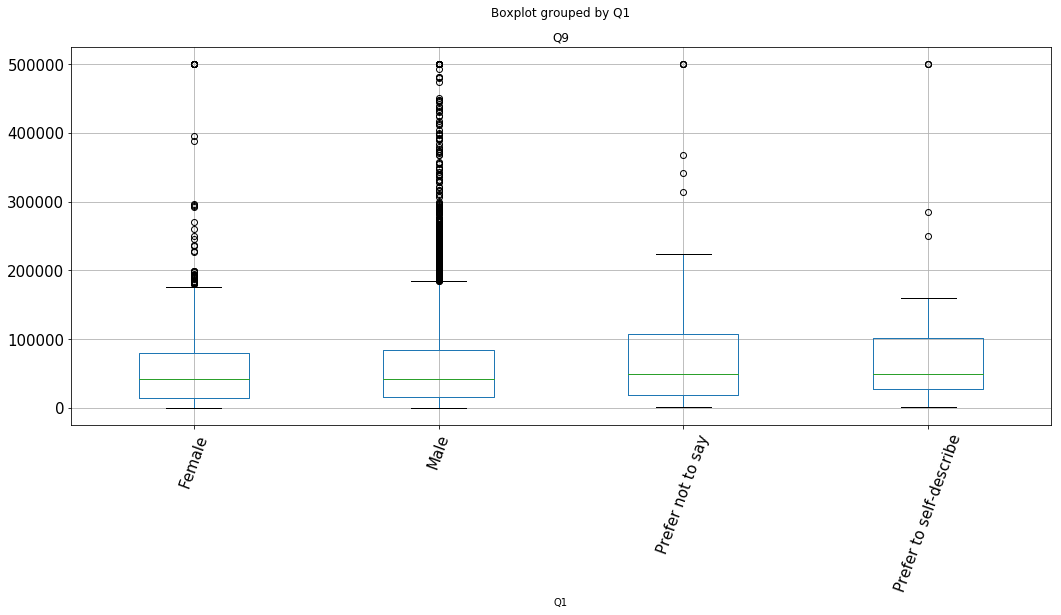

In [65]:
sal = Salaries['Q9']
gender = Salaries['Q1']
sal_gen_DF = pd.concat([gender,sal], axis = 1)
boxplot = sal_gen_DF.boxplot(column='Q9', figsize=(17,7), by= 'Q1',rot=70,fontsize=15)


In [66]:
gen = Salaries['Q1']
edu = Salaries['Q4']
sal = Salaries['Q9']
age = Salaries['Q2']
sec = Salaries['Q7']
gen_sal_DF = pd.concat([gen,sal], axis = 1)
edu_gen_sal_DF = pd.concat([gen_sal_DF,edu],axis =1)
edu_gen_sal_age_DF = pd.concat([edu_gen_sal_DF,age],axis = 1)
edu_gen_sal_age_sec_DF = pd.concat([edu_gen_sal_age_DF,sec],axis = 1)

#### Graph 1: studying the relation between genders, level of education and salary

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


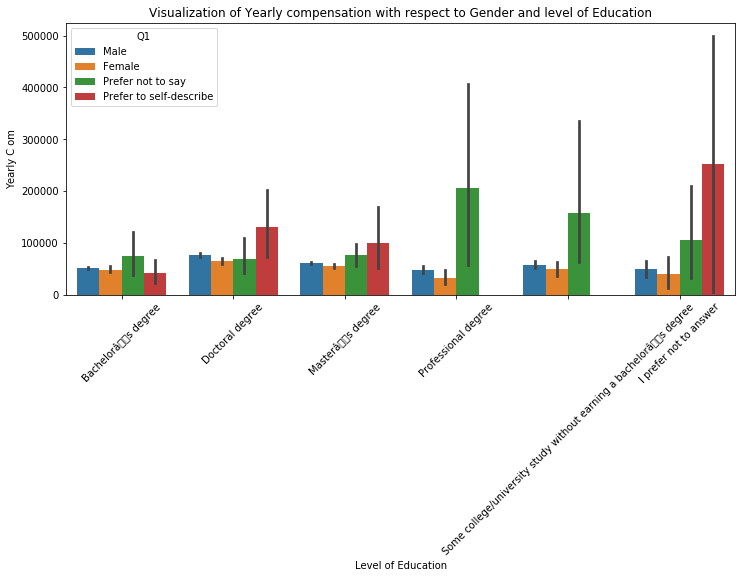

In [67]:
fig, ax = plt.subplots(figsize=(12,5))
plt.setp(plt.xticks()[1], rotation=45)
plt.title('Visualization of Yearly compensation with respect to Gender and level of Education')
sns.catplot(x="Q4", y="Q9", hue="Q1", kind="bar", data=edu_gen_sal_DF, ax=ax);
plt.close(2)
ax.set(xlabel='Level of Education', ylabel='Yearly C om')
plt.show()

Most of the sections are dominated by the gender options "prefer not to say" or "prefer to self-describe" these are the highest earning population that are taking this survey. These members make up only 1.2% of the total number of entries and the error bars are higher in these cases than in the traditional male and female categories. The ration and errors between the male and female salaries remain consistent through out the board with men earning slightly more than the women. Going off of the categories that have the least error - male and female, it is interesting to note that there is not a large pay differene between a bachelors degree and a masters degree. Those who also dont have a degree earn quite well, presumably because they took certification courses, or online courses. 

#### Graph 2: studying the relation between the level of education, age categories and the yearly salary 

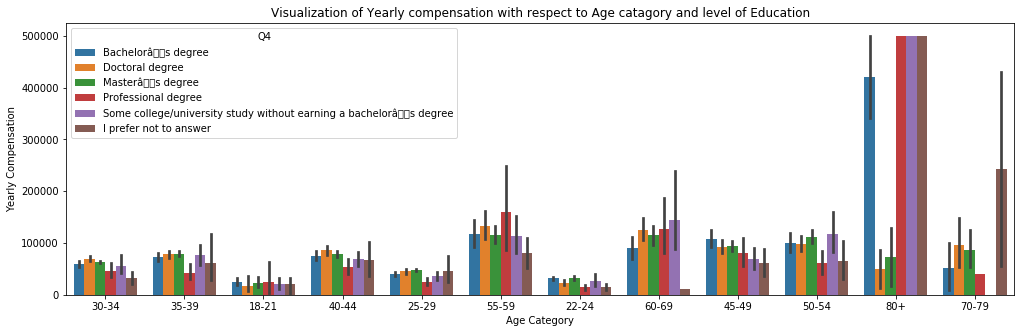

In [68]:
fig, ax = plt.subplots(figsize=(17,5))
sns.catplot(x="Q2", y="Q9", hue="Q4", 
            kind="bar", data=edu_gen_sal_age_DF,ax=ax);
plt.close(2)
plt.title('Visualization of Yearly compensation with respect to Age catagory and level of Education')
ax.set(xlabel='Age Category', ylabel='Yearly Compensation')
plt.show()

The Lowest earning age categories are 18-21 and 22-24 this is understanable because these are recent college graduates therefore do not make as much money. There is a gradual increase in the 25-29 year old category as these induviduals can be seen as the new college graduates. The salaries keep increasing at a steady pace across the age groups. It is interesting that after the age of 50- most poeople prefer to say that they recieved some form of training and not necessarily a degree. The steady rise in income accorss the age groups makes sense as the employees slowly move into executive roles with time and therefore make more money. The 80+ category shows the highest earning people where they could be retired CEOs/executives. 

#### Graph 3: studying the relation between the yearly salariey with people in different age categories and the industry they belong to. 

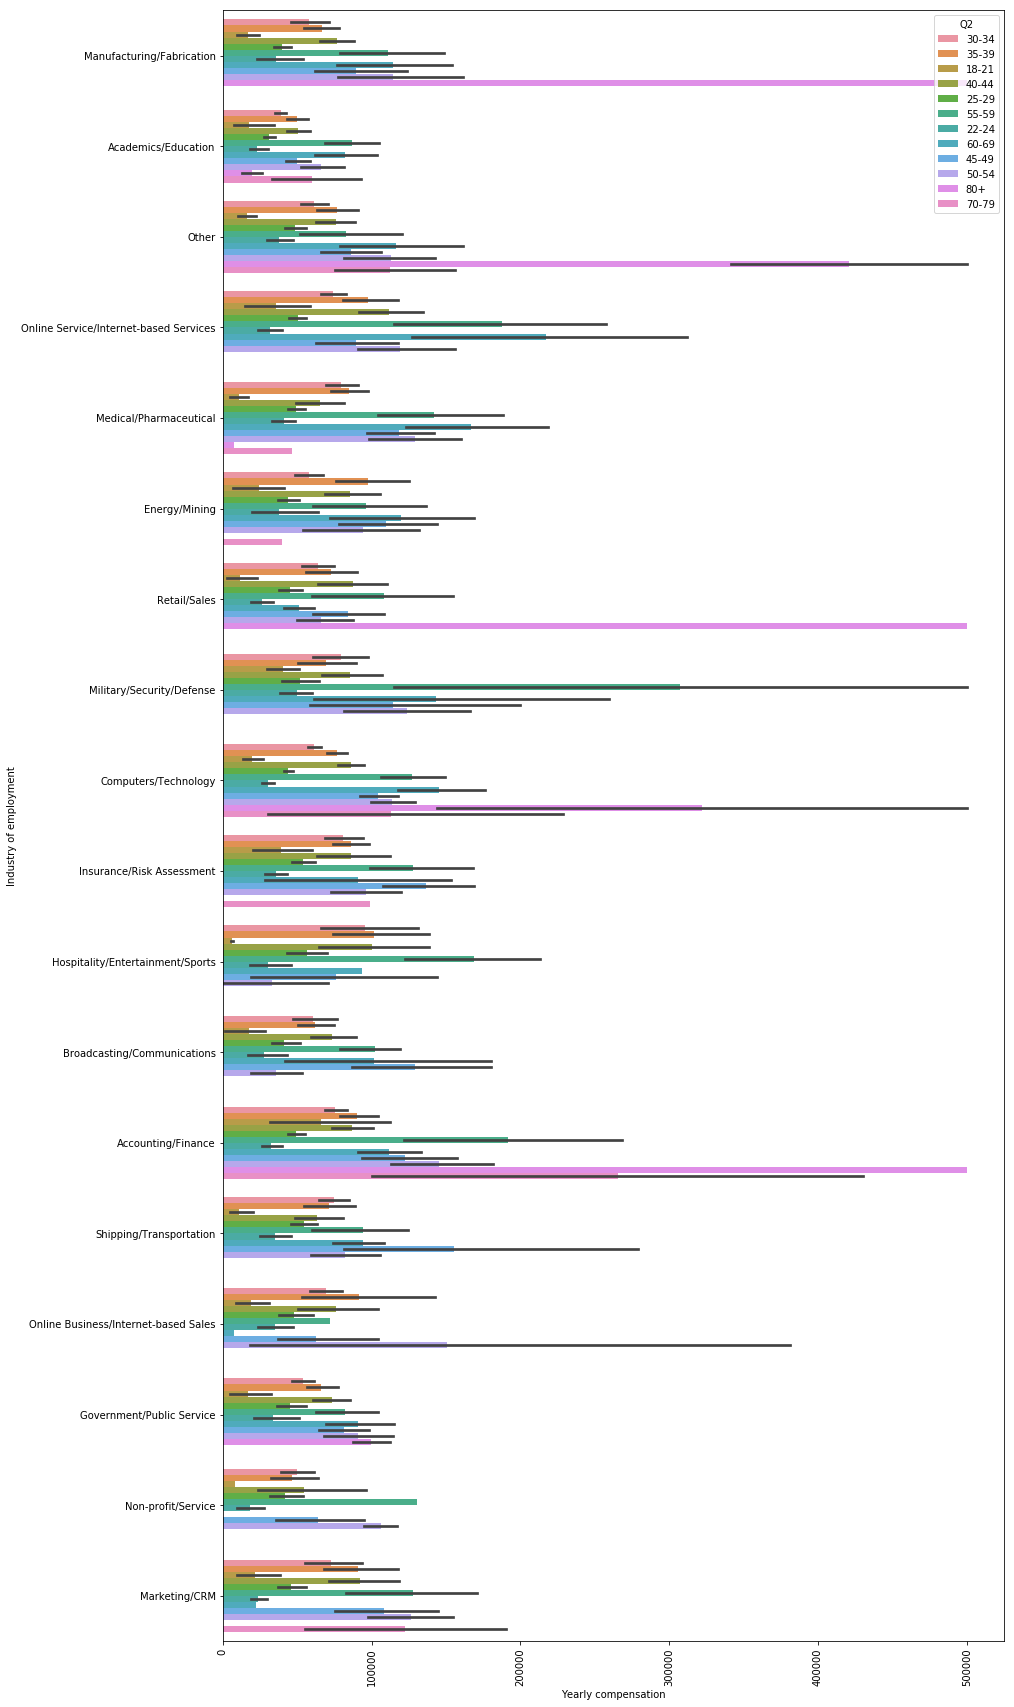

In [69]:
fig, ax = plt.subplots(figsize=(14,30))
plt.setp(plt.xticks()[1], rotation=90)
sns.catplot(y="Q7", x="Q9", hue="Q2", 
            kind="bar", data=edu_gen_sal_age_sec_DF,ax=ax);
plt.title('Visualization of Yearly compensation with respect to Age category and Industry of employment')
ax.set(xlabel='Yearly compensation', ylabel='Industry of employment')
plt.close(2)
plt.show()

People who work for the accounting and finance industry seem to one of the higher earning people and this is understandable. And education seems to be on the lower spectrum of yearly conpensation. Marketing sector does not seem to hire anyone over the age of 80. A person who is in the early twenties seems to make the most money in the line of military defense or insurance and risk management. Online services also seem to cater largely to those individuals in their twenties where they can make the most money. 

#### Visualize the order of feature importance. Some possible methods include correlation plot, or a similar method. Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?
The visualization is done using a correlation plot. 

In [70]:
#correlation map
# DO NOT RUN AGAIN
#start_time = time.time()
#f,ax = plt.subplots(figsize=(10, 10))
#toc = time.time()
#sns.heatmap(Salaries_encoded.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
#print("--- %s seconds ---" % (time.time() - start_time))

In [71]:
Sal_FE = Salaries_encoded_f.copy()
# features
features = Salaries_encoded_f.copy()
target = Salaries['Q9']


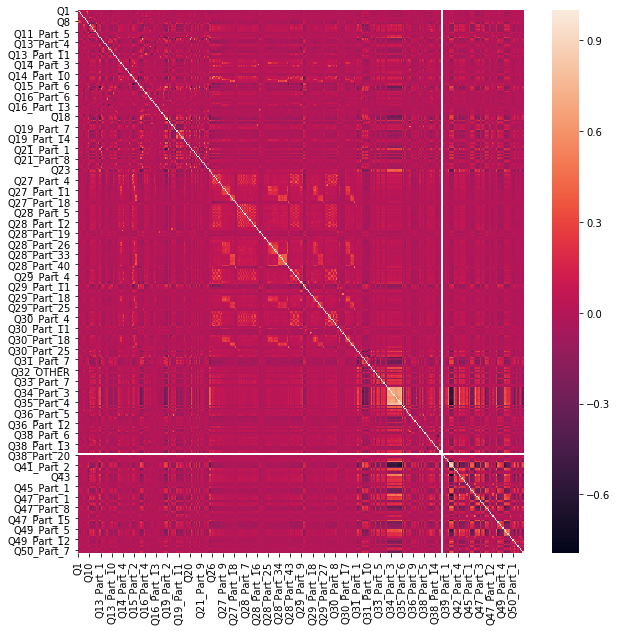

In [72]:
plt.figure(figsize=(10,10))
corr = Sal_FE.corr()
sns.heatmap(corr)

<b> First feature selection method</b> used was a simple correlation map. Generally, the confusion map is able to accurately display the features that were correctly classified. However, due to the large number of features this was not possible. However there was some insight that was drawn from the map, for example the diagonal lines suggest that the features correlated to themselves perfectly and the bright lines vertical and horizontal indicate that the values the correspond to that column had no correlation at all- due to the packed nature of the axes, it was hard to determine which column was corresponding to that line. Rest assured, the feature selections that come forth will ensure that the target variables are not dependent on this information. 

In [73]:
cor = Salaries_encoded_f.corr()
Salaries_encoded_f.shape

(12244, 360)

In [74]:
Salaries_encoded_f.columns[Salaries_encoded_f.isnull().all()]

Index([], dtype='object')

In [75]:
Q9_corr = cor['Q9']
vals = cor.columns.values
cor_q9 = pd.DataFrame([vals,Q9_corr])
cor_q9_t = cor_q9.T
#count = 0 
best_cor_pos = []
best_cor_neg = []
for q in tqdm(Q9_corr):
    if q>0.15:
        temp = cor_q9_t[cor_q9_t.values == q][0]
        #print(temp.iloc[0])
        best_cor_pos.append(temp.iloc[0])
    elif q<(-0.15):
        temp = cor_q9_t[cor_q9_t.values == q][0]
        best_cor_neg.append(temp.iloc[0])
print("Best positive corelations: ",best_cor_pos)
print("Best Negative corelations: ",best_cor_neg)

100%|██████████| 360/360 [00:00<00:00, 49597.60it/s]

Best positive corelations:  ['Q2', 'Q3', 'Q9', 'Q10']
Best Negative corelations:  ['Q11_Part_4', 'Q15_Part_2', 'Q27_Part_1', 'Q30_Part_9', 'Q38_Part_10']


Q2: What is your age (# years)? <br>
Q3: In which country do you currently reside? <br>
Q9: What is your current yearly compensation (approximate $USD)?<br>
Q10: Does your current employer incorporate machine learning methods into their business?<br>
Q11_Part_4:Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas<br>
Q15_Part_2:Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Amazon Web Services (AWS)<br>
Q27_Part_1:Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice - AWS Elastic Compute Cloud (EC2)<br>
Q30_Part_9:Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - AWS Redshift<br>
Q38_part_10: Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - FiveThirtyEight.com<br>


It is interesting to note that options with Amazon Web Services has some of the best correlations with the target varible.

## 3. Feature selection:
<b>Explain how feature engineering is a useful tool in machine learning. </b>
Feature Engineering: This step is done to reduce the number of dependencies on the target variable. In the case of this study, it can be noted that there are 300+ questions which might not all be useful information for developing a model to study the salaries of the data scientist/analyst. Feature selection studies which of the features are more relevant to the target, by reducing the features to improve accuracy scores. 

In [76]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [77]:
target = Salaries_encoded_f['Q9']
#target

<b> Then select the features to be used for analysis either manually or through some feature selection algorithm. </b> - Algorithm used is RFE (recursive feature elemination) and Linear regression for assigning the initial weights to the features. Linear regression was used as one of the first testing methods, and to keep things consistent, feature selection was also based on that. <b>RFE</b> uses a model to recursively weed out the less important features and thereby making the final list of important features more robust. The initial weight importance was applied using logistic regression model. The topic had some overlap with the correlation topics, which suggest consistency in the importance of the questions. <br>
Another alternative method that could have been used would have been PCA- however that method reduces the dimensions to two aspects, and in the interest of preserving the features and its effects on the target, they were maintained. <br> <b>ExtraTreesClassifier</b> was also used to as a control and more information on that is provided below. 

In [78]:
model = linear_model.LinearRegression()

In [79]:
rfe = RFE(model)

For the <b> RFE model</b> the features and the targets were sampled - only 5000 entries were taken which is about 50% of the entries. The entire set took up too much time and from the later steps it was clear that the linear regression fit was well generalized, hence this subset seems to be a sufficient number to draw conclusions about the entire data set. <br> It was a little confusing to see multiple features to be ranked as equally "the best" due to ranking = 1. And the columns they corresponded to didn't quite make sense either as they were the multiple choice questions and they contained a lot missing information. This is why I also tested the tree classifer model.



In [80]:
F = features[:5000]
T = target[:5000]
fit = rfe.fit(F, T)

In [81]:
#Sal_FE

In [82]:
# First used model was RFE
imp_features = sorted(list(zip(fit.ranking_,features))[0:50])
print ("The selected Important features by means of RFE were: ", imp_features)
features = []
#a= imp_features[2][1]
for i in range(len(imp_features)):
    features.append(imp_features[i][1])
    
imp_target_en1 = pd.DataFrame(Salaries_encoded_f['Q9'])
imp_feature_en1 = pd.DataFrame(Salaries_encoded_f['Q9'])

for feature in features:
    temp = Salaries_encoded_f.loc[:,feature]
    imp_feature_en1=pd.concat([imp_feature_en1,temp], axis = 1)

imp_feature_en1 = imp_feature_en1.drop(columns=['Q9'])
imp_feature_en1.shape
len(imp_features)

The selected Important features by means of RFE were:  [(1, 'Q1'), (1, 'Q11_Part_1'), (1, 'Q11_Part_2'), (1, 'Q11_Part_3'), (1, 'Q11_Part_4'), (1, 'Q11_Part_7'), (1, 'Q13_Part_10'), (1, 'Q13_Part_13'), (1, 'Q13_Part_14'), (1, 'Q13_Part_3'), (1, 'Q13_Part_6'), (1, 'Q13_Part_7'), (1, 'Q13_Part_8'), (1, 'Q13_Part_9'), (1, 'Q14_Part_11'), (1, 'Q14_Part_3'), (1, 'Q14_Part_4'), (1, 'Q14_Part_5'), (1, 'Q14_Part_7'), (1, 'Q14_Part_8'), (1, 'Q15_Part_1'), (1, 'Q15_Part_2'), (1, 'Q15_Part_4'), (1, 'Q15_Part_6'), (1, 'Q2'), (1, 'Q4'), (1, 'Q5'), (1, 'Q8'), (1, 'Q9'), (9, 'Q10'), (12, 'Q13_Part_11'), (13, 'Q15_Part_5'), (26, 'Q13_Part_5'), (29, 'Q14_Part_1'), (39, 'Q15_Part_3'), (54, 'Q13_Part_2'), (57, 'Q14_Part_6'), (58, 'Q13_Part_15'), (60, 'Q14_Part_10'), (64, 'Q11_Part_6'), (70, 'Q13_Part_4'), (71, 'Q6'), (73, 'Q14_Part_9'), (91, 'Q11_Part_5'), (94, 'Q13_Part_12'), (104, 'Q13_Part_1'), (107, 'Q12_MULTIPLE_CHOICE'), (111, 'Q3'), (120, 'Q14_Part_2'), (142, 'Q7')]


50

In [83]:
imp_features_titles = list(imp_feature_en1.columns)

In [84]:
# top 25 ranked features. 
imp_feature_en1.columns

Index(['Q1', 'Q11_Part_1', 'Q11_Part_2', 'Q11_Part_3', 'Q11_Part_4',
       'Q11_Part_7', 'Q13_Part_10', 'Q13_Part_13', 'Q13_Part_14', 'Q13_Part_3',
       'Q13_Part_6', 'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q14_Part_11',
       'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_7', 'Q14_Part_8',
       'Q15_Part_1', 'Q15_Part_2', 'Q15_Part_4', 'Q15_Part_6', 'Q2', 'Q4',
       'Q5', 'Q8', 'Q10', 'Q13_Part_11', 'Q15_Part_5', 'Q13_Part_5',
       'Q14_Part_1', 'Q15_Part_3', 'Q13_Part_2', 'Q14_Part_6', 'Q13_Part_15',
       'Q14_Part_10', 'Q11_Part_6', 'Q13_Part_4', 'Q6', 'Q14_Part_9',
       'Q11_Part_5', 'Q13_Part_12', 'Q13_Part_1', 'Q12_MULTIPLE_CHOICE', 'Q3',
       'Q14_Part_2', 'Q7'],
      dtype='object')

<b> ExtraTreesClassifier </b> The given models (Section 4) were also tested using the tree classifier feature selection method and there was minimum difference in accuracy - it remained at a constant 25% (without model tuning). I chose to do this model because I wanted to be able to compare the results from RFE which uses elimination to arrive at the best feature, where are ExtraTreesClassifier uses averaging to arrive at the best features. <br> Upon running the model, it was evident that there was very little different between the RFE model selected features and ExtraTreesClassifier selected features. However, the latter did pick up all of the first few questions that were answered by the survey respondent. These questions are considered to be important as they are discrete and hold immediate value (i.e. they are not multiple choice questions and section 2 is derived from the first few questions, where these questions can be seen to have a direct impact on the Salary)

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

F = Sal_FE.drop(['Q9'], axis = 1)
X = F[:3000]
Y = target[:3000]
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
#print(model.feature_importances_)
x= model.feature_importances_
names = list(F.columns)
tree = pd.DataFrame({"Features":names,"Scores":x})
tree_sort = tree.sort_values(['Scores'], ascending = 0)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [86]:
tree_best = tree_sort.head(50)
tree_best = tree_best['Features']
tree_best.values

array(['Q35_Part_1', 'Q39_Part_1', 'index', 'Q34_Part_1', 'Q8',
       'Q34_Part_6', 'Q5', 'Q34_Part_4', 'Q7', 'Q39_Part_2', 'Q43', 'Q6',
       'Q10', 'Q3', 'Q35_Part_3', 'Q23', 'Q40', 'Q34_Part_5', 'Q2',
       'Q34_Part_3', 'Q32', 'Q26', 'Q35_Part_4', 'Q25', 'Q35_Part_2',
       'Q46', 'Q35_Part_5', 'Q34_Part_2', 'Q41_Part_1', 'Q24', 'Q4',
       'Q20', 'Q22', 'Q17', 'Q12_MULTIPLE_CHOICE', 'Q41_Part_2', 'Q48',
       'Q13_Part_2', 'Q31_Part_8', 'Q42_Part_1', 'Q16_Part_3',
       'Q14_Part_10', 'Q13_Part_9', 'Q31_Part_9', 'Q11_Part_1',
       'Q13_Part_13', 'Q31_Part_10', 'Q21_Part_6', 'Q45_Part_4',
       'Q33_Part_1'], dtype=object)

In [87]:
# Tried to get recursive feature elimination with cross validation - however it took took long, so this part is commented it out and can 
# be tried with a better system

#rfe = RFECV(model)
#F = features[:1000]
#T = target[:1000]
#fit = rfe.fit(features, target)
#imp_features = sorted(list(zip(fit.ranking_,Sal_FE))[0:15])
#imp_features

In [88]:
# Since the important features from logistic regression already include the list of topics presented here, 
# this list of topics are not being used for the model study. 

imp_feature_en = imp_feature_en1.copy()
for item in best_cor_pos:
    if item != 'Q9':
        to_add = F[item]
    imp_feature_en = pd.concat([imp_feature_en,to_add],axis = 1)
imp_features_titles = list(imp_feature_en.columns)
for item in best_cor_neg:
    if item != 'Q9':
        to_add = F[item]
    imp_feature_en = pd.concat([imp_feature_en,to_add],axis = 1)

In [89]:
# Removing duplicates 
imp_feature_en = imp_feature_en.loc[:,~imp_feature_en.columns.duplicated()]

In [90]:
# The final list of features was a combination of the top 15 features from RFE and the top 15% correlated columns 
imp_feature_en.columns


Index(['Q1', 'Q11_Part_1', 'Q11_Part_2', 'Q11_Part_3', 'Q11_Part_4',
       'Q11_Part_7', 'Q13_Part_10', 'Q13_Part_13', 'Q13_Part_14', 'Q13_Part_3',
       'Q13_Part_6', 'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q14_Part_11',
       'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_7', 'Q14_Part_8',
       'Q15_Part_1', 'Q15_Part_2', 'Q15_Part_4', 'Q15_Part_6', 'Q2', 'Q4',
       'Q5', 'Q8', 'Q10', 'Q13_Part_11', 'Q15_Part_5', 'Q13_Part_5',
       'Q14_Part_1', 'Q15_Part_3', 'Q13_Part_2', 'Q14_Part_6', 'Q13_Part_15',
       'Q14_Part_10', 'Q11_Part_6', 'Q13_Part_4', 'Q6', 'Q14_Part_9',
       'Q11_Part_5', 'Q13_Part_12', 'Q13_Part_1', 'Q12_MULTIPLE_CHOICE', 'Q3',
       'Q14_Part_2', 'Q7', 'Q27_Part_1', 'Q30_Part_9', 'Q38_Part_10'],
      dtype='object')

In [91]:
#imp_feature_en1
#imp_target_en1

In [92]:
imp_target_en_tree = pd.DataFrame(Salaries['Q9'])
imp_feature_en_tree = pd.DataFrame(Salaries['Q9'])

for feature in tree_best: 
    temp = Salaries_encoded_f.loc[:,feature]
    imp_feature_en_tree=pd.concat([imp_feature_en_tree,temp], axis = 1)

#imp_feature_en_tree = imp_feature_en_tree.drop(columns=['Q9'])
imp_feature_en_tree.shape

(12244, 51)

In [93]:
val = tree_best.values
val = list(val)
#imp_feature_en_tree

In [94]:
# Removing duplicates 
imp_feature_en_tree = imp_feature_en_tree.loc[:,~imp_feature_en_tree.columns.duplicated()]

In [95]:
imp_feature_en_tree.shape

(12244, 51)

In [96]:
imp_target_en_tree = imp_feature_en_tree['Q9']
imp_feature_en_tree = imp_feature_en_tree.drop(columns = ['Q9'])



In [97]:
#imp_feature_en_tree1

In [98]:
'''
best_features_df = Salaries_encoded['Q3']
temp = []

for item in best_cor_pos:
    if item != 'Q3':
        entry =Salaries_encoded[item]
        best_features_df = pd.concat([best_features_df, entry], axis = 1)
print("shape1", best_features_df.shape)
#best_features_df
for item in best_cor_neg:
    entry =Salaries_encoded[item]
    best_features_df = pd.concat([best_features_df, entry], axis = 1)
names = best_features_df.columns
print("shape2", best_features_df.shape)
for item in features:
    if item not in names:
        entry =Salaries_encoded[item]
        best_features_df = pd.concat([best_features_df, entry], axis = 1)
best_features_df.head()
print("shape3", best_features_df.shape)
'''

'\nbest_features_df = Salaries_encoded[\'Q3\']\ntemp = []\n\nfor item in best_cor_pos:\n    if item != \'Q3\':\n        entry =Salaries_encoded[item]\n        best_features_df = pd.concat([best_features_df, entry], axis = 1)\nprint("shape1", best_features_df.shape)\n#best_features_df\nfor item in best_cor_neg:\n    entry =Salaries_encoded[item]\n    best_features_df = pd.concat([best_features_df, entry], axis = 1)\nnames = best_features_df.columns\nprint("shape2", best_features_df.shape)\nfor item in features:\n    if item not in names:\n        entry =Salaries_encoded[item]\n        best_features_df = pd.concat([best_features_df, entry], axis = 1)\nbest_features_df.head()\nprint("shape3", best_features_df.shape)\n'

In [99]:
# Writing data to an excel file for better data visualization 
#Salaries.to_excel("Clean_kaggle.xlsx") 

### 4. Model implementation
<b>Implement 4 different regression/prediction algorithms of your choice on the training data using 10-fold cross-validation.</b><br>
<li> Linear Regression</li>
<li> Ridge </li>
<li> Lasso </li>
<li> ElastiNet </li>

In [100]:
# Running k fold code from provided tutorial:
#set up cross validation

def run_kfold(model, Salaries_X, Salaries_Y):
    
    X = Salaries_X
    Y = Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        MSE = abs(mean_absolute_error(Y_test, predictions))
        outcomes.append(accuracy)
        print("Fold {0} R2 accuracy: {1}".format(fold, accuracy))   
        #print("Fold {0} MSE accuracy: {1}".format(fold, MSE)) 
        
    mean_outcome = np.mean(outcomes)
    mean_MSE = np.mean(MSE)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Average MSE over all folds: {0}".format(mean_MSE)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    return mean_MSE

In [101]:
def bias(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (np.mean((y_pred-y)**2))

In [102]:
def var (y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    y_avg = np.mean(y_pred)
    return (np.mean((y_pred-y_avg)**2))

In [103]:
#imp_feature_en.shape
todrop = imp_feature_en.iloc[:,13:14]
imp_feature_en = imp_feature_en.drop(todrop, axis = 1)

In [104]:
imp_feature_en1.shape

(12244, 49)

#### Model 1: Linear Regression

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model accuracy stays relatively the same across all the folds. This goes to suggest that the model is well balanced, with a uniform distribution of information.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The average variance and bias are reported below. According to the number reported, the model was not very well fit to the data. The reason linear regression model was used is that this model is a preliminary model where other, and used as a baseline to to comeapres more complex models with.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The model performance is measured using R squared for a few reasons: firstly, the mean squared error was extremely high (given the low accuracy score, it is understandable) and simple comparison became strenuous. Secondly, this model compares the variance of the predicted model versus the observed model, which is a good gauge to study how far apart the values are from one an other. The average mean square value is also reported from the k-fold run, this can then be used to be compared with all th other models. 

In [105]:
#Features=imp_feature_en 
#Salaries=imp_target_en1

Salaries = imp_target_en_tree 
Features = imp_feature_en_tree 


x_train_lin, x_test_lin, y_train_lin, y_test_lin = train_test_split(Features, Salaries, test_size=0.33, random_state=42) 

model1=linear_model.LinearRegression()
mse = run_kfold (model1,x_train_lin,y_train_lin)
y_test_pred_lin = model1.predict(x_test_lin)
y_train_pred_lin = model1.predict(x_train_lin)

R2 = r2_score(y_test_lin,y_test_pred_lin)

y_test_pred_lin = y_test_pred_lin.ravel()
      
act_pred_m1 = pd.DataFrame({'Actual': y_test_lin, 'Predicted': y_test_pred_lin}) 

train_acc = r2_score(y_train_lin,y_train_pred_lin)

print ("------------------------------")
print("R2 Score: ", R2)
print("the train accuracy is : ",train_acc)
print("the bias is : ", bias(y_test_lin,y_test_pred_lin))
print("the variance is : ", var(y_test_lin,y_test_pred_lin))
m1 = {'Bias':bias(y_test_lin,y_test_pred_lin),'Variance':var(y_test_lin,y_test_pred_lin), 'R2': R2, 'MSE from 10 folds': mse}
m1_coeff = model1.coef_
#m1_df = pd.DataFrame({'Actual': y_test_pred_lin.flatten(), 'Predicted': y_train_pred_lin.flatten()})

Fold 1 R2 accuracy: 0.2189226901118989
Fold 2 R2 accuracy: 0.30169942805157757
Fold 3 R2 accuracy: 0.21210334281431187
Fold 4 R2 accuracy: 0.2515692100737368
Fold 5 R2 accuracy: 0.3153209802015088
Fold 6 R2 accuracy: 0.22896205880593945
Fold 7 R2 accuracy: 0.31274077617777984
Fold 8 R2 accuracy: 0.2668248554983098
Fold 9 R2 accuracy: 0.21938012928231365
Fold 10 R2 accuracy: 0.22154113062957548
Mean r2: 0.2549064601646952
Average MSE over all folds: 35954.37968511814
Standard Deviation: 0.039386425953721195
------------------------------
R2 Score:  0.22999458137717899
the train accuracy is :  0.26057179568804323
the bias is :  3219204157.5203404
the variance is :  1089966300.0


In [106]:
m1_coeff_list = m1_coeff

In [107]:
# Gathering the coefficients so the effects of different models can be studied. 
#m1_coeff_list = []
#x, y = m1_coeff.shape
#for i in range(x):
#    for j in range(y):
#        m1_coeff_list.append(m1_coeff[i][j])
#m1_coeff_list = m1_coeff_list[:50]
#len(m1_coeff_list)

#### Model 2: Ridge
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;While the features of the model were reduced from ~300 to 50, the variations of each of the columns still make it a rather complex model. In an attempt to reduce this problem, Ridge and Lasso method were used. Since, the model itself is not a fitting the data very well, it can be assumed that the data cleaning was not done correctly, and ridge and lasso method are generally used to tackle the problem of overfitting. The main criteria for Ridge is that it minimizes the effect of irrelevant features in the training model. This was useful because upon visual inspection of the coefficients feature names, it was evident that some of the topics were not necessarily informative, for example, many of the questions that contained the word "part" had minimum information filled in, hence it would be expected that they were not carrying a lot of information, however, these were the questions that were mostly picked up by the feature selections. The hope is that Ridge would minimize the effect of these features on the training model.

In [108]:
#Features=imp_feature_en 
#Salaries=imp_target_en1

Salaries = imp_target_en_tree 
Features = imp_feature_en_tree 


x_train, x_test, y_train, y_test = train_test_split(Features, Salaries, test_size=0.33,  random_state=42) 

model2=linear_model.Ridge()
mse = run_kfold(model2,x_train,y_train)
model2.fit(x_train, y_train)
y_test_pred = model2.predict(x_test)
y_train_pred = model2.predict(x_train)

R2 = r2_score(y_test, y_test_pred)
#MSE = abs(mean_squared_error(y_test, y_test_pred))
y_test_pred = y_test_pred.ravel()
train_acc = r2_score(y_train,y_train_pred)    
act_pred_m2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred}) 

print ("------------------------------")
print("R2 Score: ", R2)
print("the bias is : ", bias(y_test,y_test_pred))
print("the variance is : ", var(y_test,y_test_pred))
print("the train accuracy is : ",train_acc)
m2= {'Bias':bias(y_test,y_test_pred),'Variance':var(y_test,y_test_pred), 'R2': R2, 'MSE from 10 folds': mse}
m2_coeff = model2.coef_
m2

Fold 1 R2 accuracy: 0.21886666924595344


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.150572e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.004478e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.023147e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.012036e-0

Fold 2 R2 accuracy: 0.30165348610582066
Fold 3 R2 accuracy: 0.21225188777488602
Fold 4 R2 accuracy: 0.2515380275117647
Fold 5 R2 accuracy: 0.31506426880802785


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.995117e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.933890e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.070374e-09
  overwrite_a=True).T
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.036091e-0

Fold 6 R2 accuracy: 0.22900288651319345
Fold 7 R2 accuracy: 0.31276504863820365
Fold 8 R2 accuracy: 0.26692157341916734
Fold 9 R2 accuracy: 0.21942780129690165
Fold 10 R2 accuracy: 0.22149566086145256
Mean r2: 0.25489873101753713
Average MSE over all folds: 35951.69730849848
Standard Deviation: 0.03933428818625621
------------------------------
R2 Score:  0.23067364645498678
the bias is :  3216365152.665523
the variance is :  1085889206.4825695
the train accuracy is :  0.26123969031062033


{'Bias': 3216365152.665523,
 'Variance': 1085889206.4825695,
 'R2': 0.23067364645498678,
 'MSE from 10 folds': 35951.69730849848}

In [109]:
#m2_coeff_list = []
#x, y = m2_coeff.shape
#for i in range(x):
#    for j in range(y):
#        m2_coeff_list.append(m2_coeff[i][j])
#len(m2_coeff_list)
#m2_coeff_list = m2_coeff_list[:50]
#len(m2_coeff_list)

In [110]:
m2_coeff_list = m2_coeff
m2_coeff_list.shape

(50,)

#### Model 3: Lasso 
Lasso is another regularized regression problem and the weights added to the features there by penalizing the features which have less impact on the Salaries. Since the accuracies were not improved in Ridge, it was assumed that the features that were selected were not penalized enough, and that they were still influencing the model heavily. This problem is overcome to an extent by lasso where two of the parameters were set to zero (therefore these parameters had no effect on the model). The feature selection part of this assignment should have weeded out these features so that they might not have been selected in the first place. However, it is also conceivable, that the data cleaning made it such that they all had such low correlation values that the demand for having a certain number of features (in this case 50), forced the not so relevant features to be selected. 

In [111]:
#Features=imp_feature_en 
#Salaries=imp_target_en1

Salaries = imp_target_en_tree 
Features = imp_feature_en_tree 


x_train_lass, x_test_lass, y_train_lass, y_test_lass = train_test_split(Features, Salaries, test_size=0.33, random_state=42)

model3=linear_model.Lasso()
mse = run_kfold(model3,x_train_lass,y_train_lass)
y_test_pred_lass = model3.predict(x_test_lass)
y_train_pred_lass = model3.predict(x_train_lass)

R2 = r2_score(y_test_lass, y_test_pred_lass)
#MSE = mean_squared_error(y_test, y_test_pred)
y_test_pred_lass = y_test_pred_lass.ravel()
      
act_pred_m3 = pd.DataFrame({'Actual': y_test_lass, 'Predicted': y_test_pred_lass}) 
train_acc = r2_score(y_train_lass,y_train_pred_lass)    
print ("------------------------------")
print("R2 Score: ", R2)
#print("Mean Squared Error: ", MSE)
print("the bias is : ", bias(y_test_lass,y_test_pred_lass))
print("the variance is : ", var(y_test_lass,y_test_pred_lass))
print("the train accuracy is : ",train_acc)
m3 = {'Bias':bias(y_test_lass,y_test_pred_lass),'Variance':var(y_test_lass,y_test_pred_lass), 'R2': R2, 'MSE from 10 folds': mse}

m3_coeff = list(model3.coef_)
m3_coeff = m3_coeff[:50]


Fold 1 R2 accuracy: 0.2188659201626988
Fold 2 R2 accuracy: 0.30165959365818695
Fold 3 R2 accuracy: 0.21224670226590392
Fold 4 R2 accuracy: 0.2515345589441885
Fold 5 R2 accuracy: 0.3150828527120756
Fold 6 R2 accuracy: 0.22900577964620727
Fold 7 R2 accuracy: 0.3127770887848217
Fold 8 R2 accuracy: 0.26692452256223576
Fold 9 R2 accuracy: 0.21942957485559877
Fold 10 R2 accuracy: 0.22150708166025712
Mean r2: 0.2549033675252175
Average MSE over all folds: 35951.48359375
Standard Deviation: 0.03933905871905223
------------------------------
R2 Score:  0.23000802802603815
the bias is :  3219147940.373207
the variance is :  1089100300.0
the train accuracy is :  0.26057049083760786


#### Model 4: ElasticNet
Elastic net is a combination of the previous two method, Ridge and Lasso. The reason for this is that Elastic net works very well on features that are correlated and given that so many of the features were parts of one larger question (i.e. Q14_part_1, Q14_part_2, Q14_part_3, etc.) it was assumed that they would be some how correlated. However the low accuracy rates prove otherwise. To keep the performance measures consistent for later comparison, r2_score was used. 

In [112]:
#Features=imp_feature_en 
#Salaries=imp_target_en1

Salaries = imp_target_en_tree 
Features = imp_feature_en_tree 

x_train, x_test, y_train, y_test = train_test_split(Features, Salaries, test_size=0.33, random_state=42) 

model4 = linear_model.ElasticNet()
mse = run_kfold (model4,x_train,y_train)
model4.fit(x_train,y_train)
y_test_pred = model4.predict(x_test)
y_train_pred = model4.predict(x_train)

R2 = r2_score(y_test, y_test_pred)
#MSE = mean_squared_error(y_test, y_test_pred)
y_test_pred = y_test_pred.ravel()
      
act_pred_m4 = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred}) 
train_acc = r2_score(y_train,y_train_pred)  
print ("------------------------------")
print("R2 Score: ", R2)
#print("Mean Squared Error: ", MSE)
print("the bias is : ", bias(y_test,y_test_pred))
print("the variance is : ", var(y_test,y_test_pred))
print("the train accuracy is : ",train_acc)
m4 = {'Bias':bias(y_test,y_test_pred),'Variance':var(y_test,y_test_pred), 'R2': R2, 'MSE from 10 folds': mse}
m4_coeff = list(model4.coef_)
m4_coeff = m4_coeff[:50]


Fold 1 R2 accuracy: 0.20984729554039294
Fold 2 R2 accuracy: 0.2858316774007037
Fold 3 R2 accuracy: 0.21091270174822963
Fold 4 R2 accuracy: 0.24445785196633785
Fold 5 R2 accuracy: 0.30241453072236646
Fold 6 R2 accuracy: 0.21881824124144633
Fold 7 R2 accuracy: 0.3055783908029449
Fold 8 R2 accuracy: 0.26284121132014504
Fold 9 R2 accuracy: 0.21804089912840252
Fold 10 R2 accuracy: 0.2101286954253282
Mean r2: 0.24688714952962978
Average MSE over all folds: 36137.59628310785
Standard Deviation: 0.03733942566410589
------------------------------
R2 Score:  0.22881812413112013
the bias is :  3224122637.268744
the variance is :  880632269.238087
the train accuracy is :  0.25108199319580826


In [113]:

Results = pd.DataFrame([m1,m2,m3,m4])
Results.rename(index={0:'Linear Regression',1:'Ridge',2:'Lasso',3:'Elastic Net', 4:'average MSE from 10 folds'}, inplace=True)


#### Visualization of the perfomance of coefficients across all the features. 
This was mostly used for discussion purposes and to get an idea of how the model dealt with all the different features. For example Q29 part 2 was a question that was highly peanlized, this could be due to the fact that question had a significant portion of its data missing.  Elastic net model is the most damped model according to the graph and this is evident as it has the smallest variance score among all the other graphs. 

No handles with labels found to put in legend.


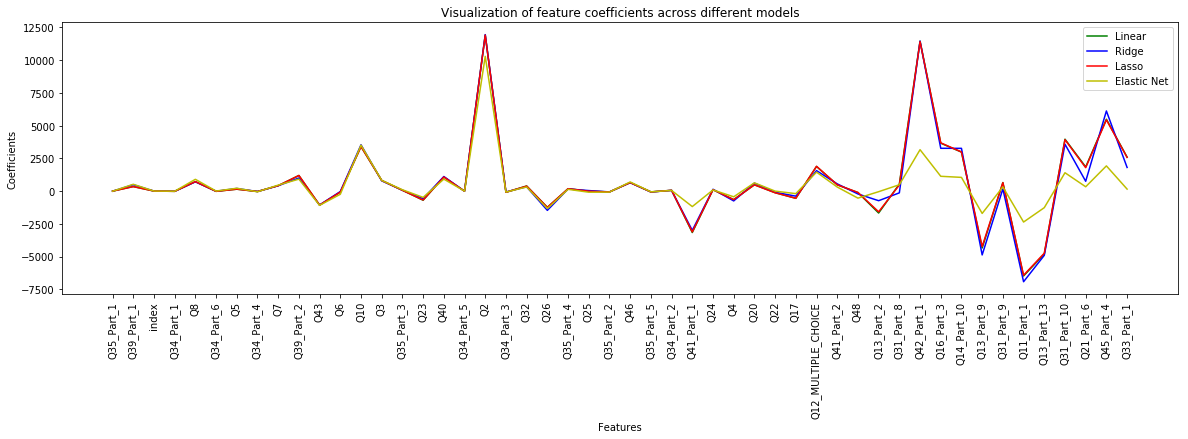

In [114]:
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(plt.xticks()[1], rotation=90)
plt.title('Visualization of feature coefficients across different models')
#sns.catplot(x="Title", y="lin", data=coeff1, ax=ax);
features = tree_best.values
a = plt.plot(features, m1_coeff, color='g')
b = plt.plot(features, m2_coeff_list, color='b')
c = plt.plot(features, m3_coeff, color='r')
d = plt.plot(features, m4_coeff, color='y')
plt.close(2)
plt.legend()
ax.set(xlabel='Features', ylabel='Coefficients')
plt.legend((a[0], b[0], c[0], d[0]), ('Linear', 'Ridge', 'Lasso', 'Elastic Net'))
plt.show()


### 5. Model Tuning: 

<b> Model turning for Linear Regression model</b>

In [115]:
#Parameters to test
Features=imp_feature_en 
Salaries=imp_target_en1

params = {'n_jobs':np.arange(1,10,1), 'fit_intercept':[True,False], 'normalize':[True,False]}

# Compare parameters by score of model 
scorer= make_scorer(r2_score)

# Run the grid search
grid_search= GridSearchCV(model1, params, scoring=scorer)
grid_search = grid_search.fit(x_train_lin, y_train_lin)

grid_search_best = grid_search.best_estimator_  #Select best parameter combination
#print('the hyper parameters for linear regression are: ', grid_search_best)
#print('Post optimized training score: ',grid_search_best.score(x_train_lin,y_train_lin))
#print('Post optimized testing score: ',grid_search_best.score(x_test_lin,y_test_lin))

grid_search_best = grid_search_best.fit(Features, Salaries)
coeff_lin = np.array(grid_search_best.coef_)
#grid_search_best = grid_search.best_estimator_ 
print("Post optimized score: ",grid_search_best.score(Features, Salaries))
grid_search_best

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Post optimized score:  0.27520531235830625


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

<b>Hyper Parameter and grid search for Ridge, LASSO and Elastic Net</b> tuning by testing a range of hyperparameters and plotting them in a log axis graph to study what is the optimum regularization value for the model to perform at its best. According to the graph, the default value of Alpha = 1, worked the best and provided the best results. 

In [116]:
Features=imp_feature_en 
Salaries=imp_target_en1
def grid(model):
#reg_gridsearch = linear_model.Lasso(random_state=42)
#Parameters to test
    alphas = np.linspace(.01, 100, 50)
    a = list(alphas)
    parameters = {'alpha':a, # Constant that multiplies the L1 term. Defaults to 1.0.
                 'normalize':[True,False]} 

    # Compare parameters by score of model 
    acc_scorer_lm = make_scorer(r2_score)

    # Run the grid search
    grid_search = GridSearchCV(model, parameters, scoring=acc_scorer_lm)
    grid_search = grid_search.fit(Features, Salaries)
    
    reg_gridsearch = grid_search.best_estimator_  #Select best parameter combination
    print(reg_gridsearch)
    reg_gridsearch.fit(Features, Salaries)
    
    coeff = np.array(reg_gridsearch.coef_)
    
    print("Post optimized score: ",reg_gridsearch.score(Features, Salaries))
    
    return reg_gridsearch, coeff

In [117]:
Features.shape

(12244, 51)

<b> EXTRA </b> Visualization of train and test scores with the best optimization results from the grid search 
The graph seen before was 

In [118]:
# Improving the performances of the models using hyper parameter tuning 
result_list = []
 
for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    #df1 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions1}) 

    Test_Score = r2_score(y_test, y_test_pred)
        # train a logistic regression classifier with a variable hyperparameter
    
    model6=linear_model.ElasticNet(alpha=param, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False).fit(x_train, y_train)

        # predict on train and test set
    y_test_pred = model6.predict(x_test)
    y_train_pred = model6.predict(x_train)

        # calculate train and test accuracy
    train_accuracy = r2_score(y_train, y_train_pred)
    test_accuracy = r2_score(y_test, y_test_pred)
        
        # add to result_list
    result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])


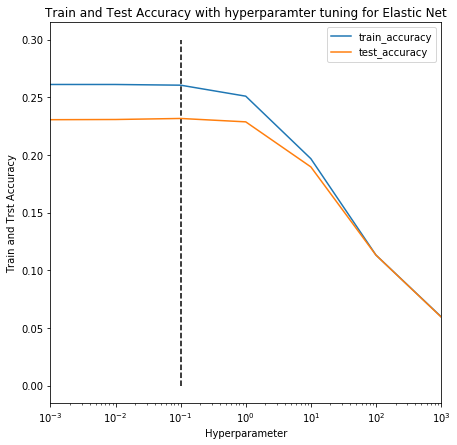

In [119]:
fig, ax = plt.subplots(figsize=(7,7))
plt.setp(plt.xticks()[1], rotation=90)
result_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True, ax = ax)
plt.title('Train and Test Accuracy with hyperparamter tuning for Elastic Net')
ax.set(xlabel='Hyperparameter', ylabel='Train and Trst Accuracy')
plt.close(2)
#lt.Axes.axvline(x=1,ax = ax)
plt.vlines(x = 0.1, ymin = 0, ymax = 0.30, linestyles = 'dashed')
plt.show()

<b>Hyper Parameter and grid search for Lasso</b> tuning by testing a range of hyperparameters and plotting them in a log axis graph to study what is the optimum regularization value for the model to perform at its best. According to the graph, the default value of Alpha = 1, worked the best and provided the best results.


In [ ]:
lasso_grid, coeff_lass = grid(model3)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
ElasticNet_grid, coeff_elas = grid(model4)

In [ ]:
Ridge_grid, ridge_coeff = grid(model2)

In [ ]:
coeff_lin_list = []
x, y = coeff_lin.shape
for i in range(x):
    for j in range(y):
        #print (coeff_lin[i][j])
        coeff_lin_list.append(coeff_lin[i][j])
coeff_lin_list = coeff_lin_list[:50]

ridge_coeff_list = []
x, y = ridge_coeff.shape
for i in range(x):
    for j in range(y):
        ridge_coeff_list.append(ridge_coeff[i][j])
ridge_coeff_list = ridge_coeff_list[:50]

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(plt.xticks()[1], rotation=90)
plt.title('Visualization of feature coefficients across different models - post model optimization ')
#sns.catplot(x="Title", y="lin", data=coeff1, ax=ax);
a = plt.plot(features, coeff_lin_list, color='g')
b = plt.plot(features, coeff_lass[:50], color='b')
c = plt.plot(features, ridge_coeff_list, color='r')
d = plt.plot(features, coeff_elas[:50], color='y')
ax.set(xlabel='Features', ylabel='Coefficients')
plt.legend((a[0], b[0], c[0], d[0]), ('Linear', 'Ridge', 'Lasso', 'Elastic Net'))
plt.show()



### 6. Testing & Discussion

In [ ]:
Results

In [ ]:
post = [0.2752053116262779,0.2742642365864655,0.2739435461560258,0.27468371066158925]
Results['Post parameter optimization'] = post
#Results = Results.drop(['post'], axis = 1)
Results

In [132]:
train_acc = [ 0.26269028992400323,0.2633802904599646,0.26270078306762035,0.25247920308759786]
Results['Train Accuracy'] = train_acc

In [133]:
Results

,Bias,MSE from 10 folds,R2,Variance,Post parameter optimization,Train Accuracy
Linear Regression,3.163472e+09,35181.689650,0.243325,1.105434e+09,0.275205,0.262690
Ridge,3.160135e+09,35175.638252,0.244123,1.103419e+09,0.274264,0.263380
Lasso,3.163458e+09,35175.650655,0.243328,1.106189e+09,0.273944,0.262701
Elastic Net,3.194527e+09,35774.353935,0.235897,8.844669e+08,0.274684,0.252479


<b>Use your optimal model to make predictions on the test set. How does your model perform on the test set vs. the training set?</b><br>
The optimal model was Linear regression according to the r2 score of the parameter tuned version at 27.69%. The differences between all the models were extremely marginal, therefore all the models were tuned. The mean squared error from all four models (tested over 10 folds) remained quite consistent. This is inline with the consistent R2 score<br><li>Linear Regression, even though it is considered a primitive method, held up in comparison with the other more complex models. The bias and variance were equally large to suggest that the model did not fit better either way. Once the parameters were tuned, a small increased in the accuracy is seen. The tuned linear regression followed : <i>LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)</i> <br> <li>The second method studied was the Ridge method which was expected to do better than the linear regression method - which it did, but to a smaller scale. the tuned model is: <i> Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001</i> The large lamda score suggests that the model was penalizing the coefficients of the features heavily in an attempt to reduce the variance of the model. This is was true where a large reduction is variance was seen. The model did show a 1% improvement after the hyperparameter was tuned. <br><li> The first method and most promising method was Lasso where the advantage of completely eliminating the unimportant coefficients was present, which the model did, however, this did not have a large impact on the accuracy value. The tuned model is: <i>Lasso(alpha=4.091224489795918, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)</i>. The hyper parameter is chosen set at a midway point (where the other models were chosen at the limits). <br><li> The final method Elastic Net had the second best post optimization score, the only insight that can be drawn from this model is that the features are not very dependent on each other, therefore the premise on which this model was used was incorrect. The tuned model is :<i>ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)</i> The hyperparameter chosen was in the lower limit of the range provided, however it was noted that the smalled provided alpha value was always chosen to be the hyperparameter for this model. This became problematic as an optimal solution could not be reached and it came down to the manual values that were provided. This reduction in the number of features (which is a result of the property of the this model) caused a change in the value for variance

<b>The overall fit of the model, how to increase the accuracy (test, training)? Is it overfitting or underfitting? Why?</b><br>
The curve was neither under nor over fitted, however since the bias was five times as large as the variance it can be noted that the curve was leaning more towards fitting the data points rather than providing a straight line. <b>The Graph below </b> provides a visual representation of the elastic net model with the actual and predicted salaries. It can be seen that model did predict values to keep them consistent and reduce the outliers were reduced as a result of the small hyper parameter chosen. The reason could be a variety of factors, however the feature selection and data cleaning seems to be the biggest problems in this situation. The multiple types of entries (multiple choice, choose the right option, text, etc.) caused an inconsistency in the data cleaning for the models. 

### Concluding Thoughts:
No conclusions could be drawn from the bias variance tradeoff in regards to choosing the best model as both of the values are extremely large and there is very little difference across the models. <br><br>
The constant performance of the dataset across the different models leads one to believe that perhaps there was an issue with the cleaning of the data and some of the methods employed there. Further investigation done in that section would be extremely useful. Another important aspect of procuring the data is the encoding of the text information. I choose to do label encoding, however in retrospect, one hot encoding would have been the more sound choice as the problem of misinterpreting labels for values could have been avoided. The feature selection portion of the project could have also been improved drastically if the data was cleaned more effectively. The correlation values brought back only 1 result with a maximum of 20% correlation - this value should have been higher is better prediction accuracy was expected. This suggests that the issue with such low scores lie in the work done before that section. 

#### Extra - for visualization purposes only

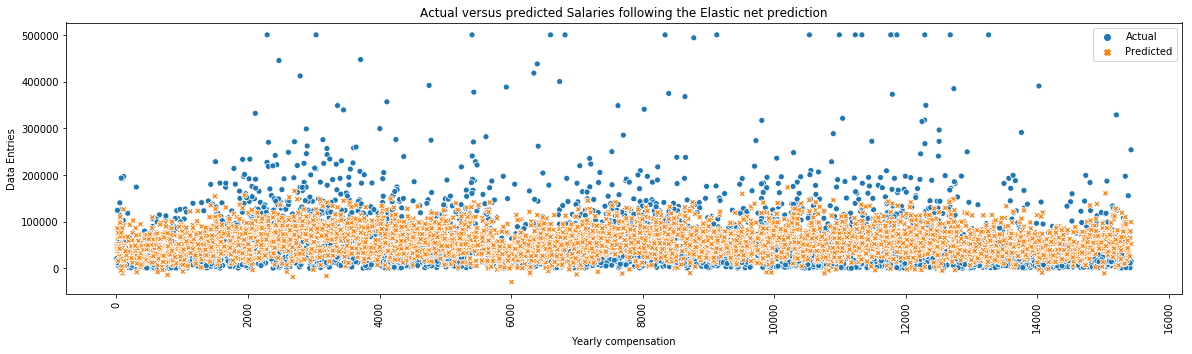

In [134]:
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(plt.xticks()[1], rotation=90)
sns.scatterplot(data=act_pred_m4)
plt.title('Actual versus predicted Salaries following the Elastic net prediction')
ax.set(xlabel='Yearly compensation', ylabel='Data Entries')
plt.close(2)
plt.show()

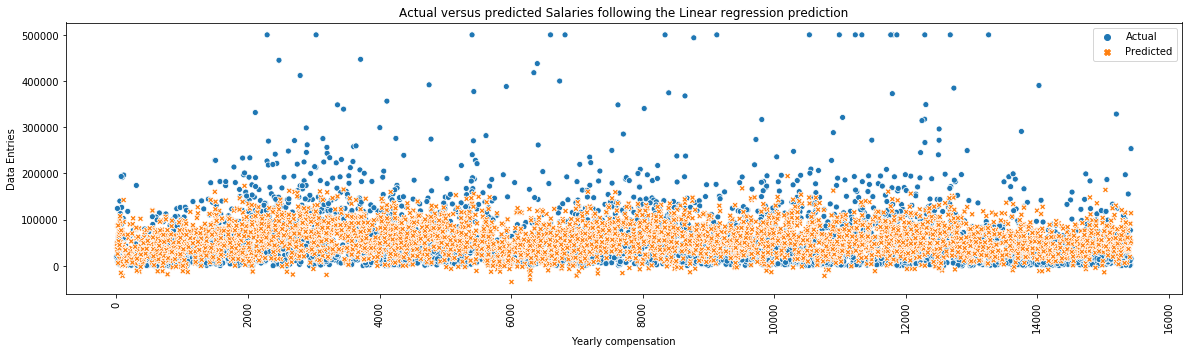

In [135]:
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(plt.xticks()[1], rotation=90)
sns.scatterplot(data=act_pred_m1)
plt.title('Actual versus predicted Salaries following the Linear regression prediction')
ax.set(xlabel='Yearly compensation', ylabel='Data Entries')
plt.close(2)
plt.show()